Reference: https://facebook.github.io/prophet/docs/diagnostics.html#parallelizing-cross-validation

# Setup

In [ ]:
import warnings
import itertools
import os
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

!pip install statsmodels --upgrade

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
!pip install pmdarima
from pmdarima.arima import auto_arima

from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet

from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.7/dist-packages (0.12.2)


# Import Dataset

## For Desktop

In [ ]:
# wanliu = pd.read_csv('/Users/isabellachittumuri/Desktop/Projects/STAT 715/PRSA_Data_Wanliu_20130301-20170228.csv')

## select columns
# wanliu = wanliu[["year", "month", "day", "hour", "PM2.5"]]

## into datetime
# wanliu['Datetime']=pd.to_datetime(wanliu[['year','month','day', 'hour']])

## keep only 2 columns
# wanliu = wanliu[["Datetime", "PM2.5"]]

## sort by date & time
# wanliu['Datetime'] = pd.to_datetime(wanliu['Datetime'])
# wanliu.sort_values(by=['Datetime'], axis=0, ascending=True, inplace=True)
# wanliu.reset_index(inplace=True, drop=True)

## display the first couple of rows
# wanliu.head()


## For Google Drive

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Data Preprocessing

In [ ]:
# let's only read one of the region's power consumptions, to keep this notebook concise
wanliu = pd.read_csv('/content/drive/MyDrive/715_project/PRSA_Data_Wanliu_20130301-20170228.csv', header=0, index_col=0, squeeze=True)

# select columns
wanliu = wanliu[["year", "month", "day", "hour", "PM2.5"]]

# into datetime
wanliu['Datetime']=pd.to_datetime(wanliu[['year','month','day', 'hour']])

# keep only 2 columns
wanliu = wanliu[["Datetime", "PM2.5"]]

# sort by date & time
wanliu['Datetime'] = pd.to_datetime(wanliu['Datetime'])
wanliu.sort_values(by=['Datetime'], axis=0, ascending=True, inplace=True)
wanliu.reset_index(inplace=True, drop=True)

# display the first couple of rows
wanliu.head()

,Datetime,PM2.5
0,2013-03-01 00:00:00,8.0
1,2013-03-01 01:00:00,9.0
2,2013-03-01 02:00:00,3.0
3,2013-03-01 03:00:00,11.0
4,2013-03-01 04:00:00,3.0


In [ ]:
wanliu.describe()

,PM2.5
count,34682.000000
mean,83.374716
std,81.905568
min,2.000000
25%,23.000000
50%,59.000000
75%,116.000000
max,957.000000


In [ ]:
print('Time period start: {}\nTime period end: {}'.format(wanliu["Datetime"].min(),wanliu["Datetime"].max()))

Time period start: 2013-03-01 00:00:00
Time period end: 2017-02-28 23:00:00


In [ ]:
wanliu.columns

Index(['Datetime', 'PM2.5'], dtype='object')

In [ ]:
wanliu.shape

(35064, 2)

In [ ]:
# check if there are duplicates
boolean = wanliu.duplicated().any() # False
boolean = wanliu.duplicated(subset=['Datetime','PM2.5']).any()
print(boolean)

False


False here - no duplicates row-wise 

In [ ]:
# convert the column (it's a string) to datetime type
datetime_series = pd.to_datetime(wanliu['Datetime'])

# create datetime index passing the datetime series
datetime_index = pd.DatetimeIndex(datetime_series.values)

df=wanliu.set_index(datetime_index)

# we don't need the column anymore
df.drop('Datetime',axis=1,inplace=True)

print(df.index)

DatetimeIndex(['2013-03-01 00:00:00', '2013-03-01 01:00:00', '2013-03-01 02:00:00', '2013-03-01 03:00:00', '2013-03-01 04:00:00', '2013-03-01 05:00:00', '2013-03-01 06:00:00', '2013-03-01 07:00:00', '2013-03-01 08:00:00', '2013-03-01 09:00:00',
               ...
               '2017-02-28 14:00:00', '2017-02-28 15:00:00', '2017-02-28 16:00:00', '2017-02-28 17:00:00', '2017-02-28 18:00:00', '2017-02-28 19:00:00', '2017-02-28 20:00:00', '2017-02-28 21:00:00', '2017-02-28 22:00:00', '2017-02-28 23:00:00'], dtype='datetime64[ns]', length=35064, freq=None)


## Fill Missing Values

In [ ]:
# Count total NaN in a DataFrame
print(" \nCount total NaN in a DataFrame : \n\n",
       df.isnull().sum().sum())

 
Count total NaN in a DataFrame : 

 382


In [ ]:
# uninterruped custom date range
date_range = pd.date_range(start=min(df.index), 
                           end=max(df.index), 
                           freq='H')

# this will append the previously missing datetimes, and create null values in our target variable
df = df.reindex(date_range)

# we fill in the blanks with values that lie on a linear curve between existing data points
df['PM2.5'].interpolate(method='linear', inplace=True)

# now we have a neatly continuous datetime index
print(f'The df.index.freq is now: {df.index.freq}, indicating that we no longer have missing instances')

The df.index.freq is now: <Hour>, indicating that we no longer have missing instances


In [ ]:
# check is any missing values left
print(" \nCount total NaN in a DataFrame : \n\n",
       df.isnull().sum().sum())

 
Count total NaN in a DataFrame : 

 0


# 24-Hour Average

In [ ]:
# daily
daily_avg = df.groupby(pd.Grouper(freq='D')).mean()

daily_avg.head()

,PM2.5
2013-03-01,8.000000
2013-03-02,29.083333
2013-03-03,80.125000
2013-03-04,22.875000
2013-03-05,134.041667


## Create Df Copy

In [ ]:
daily_avg_copy =  daily_avg
daily_avg_copy.head()

,PM2.5
2013-03-01,8.000000
2013-03-02,29.083333
2013-03-03,80.125000
2013-03-04,22.875000
2013-03-05,134.041667


# Prophet

- Prophet is open source software released by Facebook's Core Data Science team.
- Prophet is a procedure for forecasting time series data based on an additive/multiplicative model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.
- It works best with time series that have strong seasonal effects and several seasons of historical data.
- Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.
- The Prophet package provides intuitive parameters which are easy to tune.

## Training Data

Train = all observations

In [ ]:
daily_avg_copy.count()

PM2.5    1461
dtype: int64

In [ ]:
train_set = daily_avg_copy.dropna()

In [ ]:
print(train_set.count())

PM2.5    1461
dtype: int64


In [ ]:
# https://facebook.github.io/prophet/docs/quick_start.html#python-api
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

In [ ]:
# format data for prophet model using 'ds' and 'y'
train_prophet = train_set\
                    .reset_index()\
                    .rename(columns={
                        'index':'ds', 
                        'PM2.5':'y'
                    })

## Model Original Data

In [ ]:
# linear trend
# 95% CI
# CN=China
# add quarterly seasonality
prophet = Prophet(growth='linear', yearly_seasonality=True, interval_width=0.95, seasonality_mode="additive")
prophet.add_country_holidays(country_name='CN')
prophet.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')

prophet.fit(train_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
forecast = prophet.predict(train_prophet)

In [ ]:
# to see what Chinese holidays were included
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Chinese New Year,Chinese New Year_lower,Chinese New Year_upper,Dragon Boat Festival,Dragon Boat Festival_lower,Dragon Boat Festival_upper,Labor Day,Labor Day_lower,Labor Day_upper,Mid-Autumn Festival,Mid-Autumn Festival_lower,Mid-Autumn Festival_upper,National Day,National Day_lower,National Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,Tomb-Sweeping Day,Tomb-Sweeping Day_lower,Tomb-Sweeping Day_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,quarterly,quarterly_lower,quarterly_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-03-01,101.135668,7.781833,265.811805,101.135668,101.135668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.930340,31.930340,31.930340,0.0,0.0,0.0,-178.485524,-178.485524,-178.485524,3.090026,3.090026,3.090026,207.325838,207.325838,207.325838,0.0,0.0,0.0,133.066008
1,2013-03-02,101.106481,10.778384,260.864839,101.106481,101.106481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.719130,38.719130,38.719130,0.0,0.0,0.0,-200.070087,-200.070087,-200.070087,7.557932,7.557932,7.557932,231.231284,231.231284,231.231284,0.0,0.0,0.0,139.825610
2,2013-03-03,101.077293,6.605501,268.225974,101.077293,101.077293,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.335088,33.335088,33.335088,0.0,0.0,0.0,-220.447097,-220.447097,-220.447097,0.792094,0.792094,0.792094,252.990091,252.990091,252.990091,0.0,0.0,0.0,134.412382
3,2013-03-04,101.048106,-0.230267,249.786104,101.048106,101.048106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.286346,26.286346,26.286346,0.0,0.0,0.0,-239.850121,-239.850121,-239.850121,-6.118077,-6.118077,-6.118077,272.254545,272.254545,272.254545,0.0,0.0,0.0,127.334452
4,2013-03-05,101.018919,-1.419134,260.228720,101.018919,101.018919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.261391,28.261391,28.261391,0.0,0.0,0.0,-258.186286,-258.186286,-258.186286,-2.264965,-2.264965,-2.264965,288.712642,288.712642,288.712642,0.0,0.0,0.0,129.280310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2017-02-24,74.681316,-56.779761,203.667469,74.681316,74.681316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.119003,-0.119003,-0.119003,0.0,0.0,0.0,-72.639810,-72.639810,-72.639810,3.090026,3.090026,3.090026,69.430781,69.430781,69.430781,0.0,0.0,0.0,74.562313
1457,2017-02-25,74.680311,-49.238872,217.836269,74.680311,74.680311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.252133,3.252133,3.252133,0.0,0.0,0.0,-102.378536,-102.378536,-102.378536,7.557932,7.557932,7.557932,98.072737,98.072737,98.072737,0.0,0.0,0.0,77.932444
1458,2017-02-26,74.679307,-60.828212,199.334225,74.679307,74.679307,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.570192,-2.570192,-2.570192,0.0,0.0,0.0,-129.967739,-129.967739,-129.967739,0.792094,0.792094,0.792094,126.605453,126.605453,126.605453,0.0,0.0,0.0,72.109115
1459,2017-02-27,74.678302,-58.142263,187.926956,74.678302,74.678302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.774467,-6.774467,-6.774467,0.0,0.0,0.0,-155.262117,-155.262117,-155.262117,-6.118077,-6.118077,-6.118077,154.605727,154.605727,154.605727,0.0,0.0,0.0,67.903835


Text(17.475, 0.5, 'PM2.5 (ug/m3)')

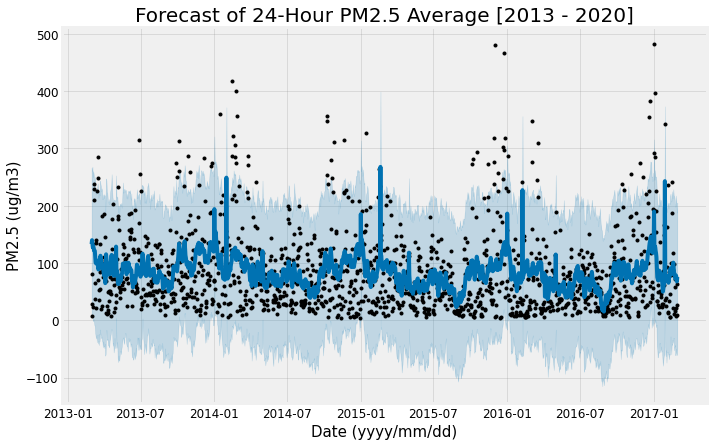

In [ ]:
#fig = prophet.plot(forecast, xlabel= 'Date (yyyy/mm/dd)', ylabel='PM2.5 (ug/m3)')
figsize=(20, 12)
fig = prophet.plot(forecast, xlabel='Date', ylabel='Value')
ax = fig.gca()
ax.set_title("Forecast of 24-Hour PM2.5 Average [2013 - 2020]", size=20)
ax.set_xlabel("Date (yyyy/mm/dd)", size=15)
ax.set_ylabel("PM2.5 (ug/m3)", size=15)

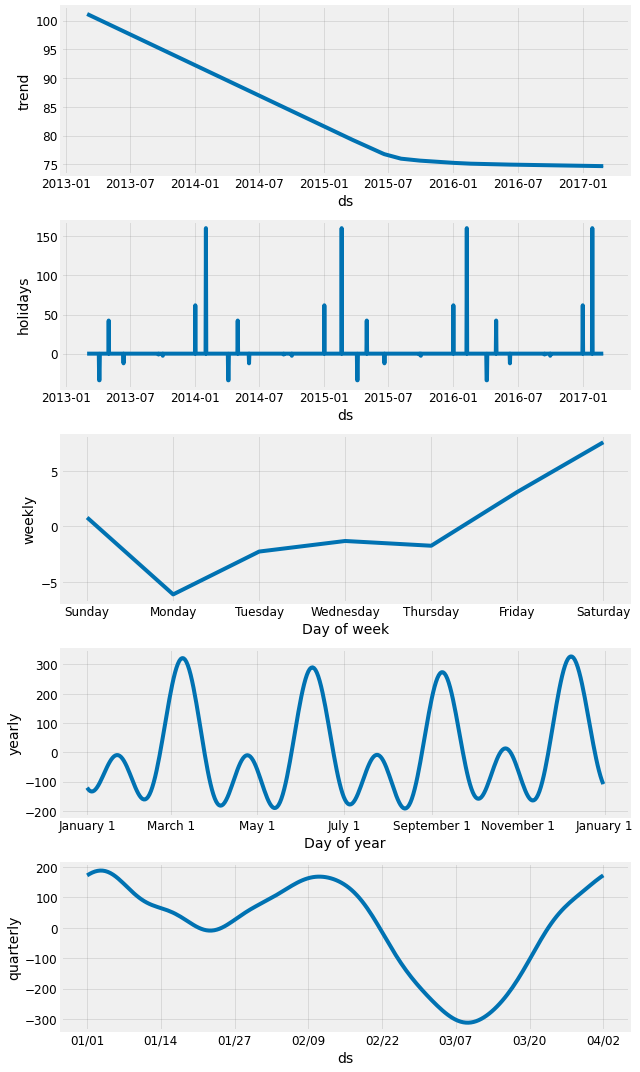

In [ ]:
fig1 = prophet.plot_components(forecast)

### Error Metrics

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['mape'] = mean_absolute_percentage_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [ ]:
evaluate_forecast(y=train_prophet['y'],
                   pred=forecast['yhat'])

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.128268,48.885988,38.474881,4350.746359,0.774057,136.1054,65.960188


In [ ]:
total_df = pd.concat([forecast.reset_index()['ds'],forecast['yhat'],train_prophet['y'][:1154]],axis=1)

Text(0.5, 1.0, 'Residuals distribution (test set)')

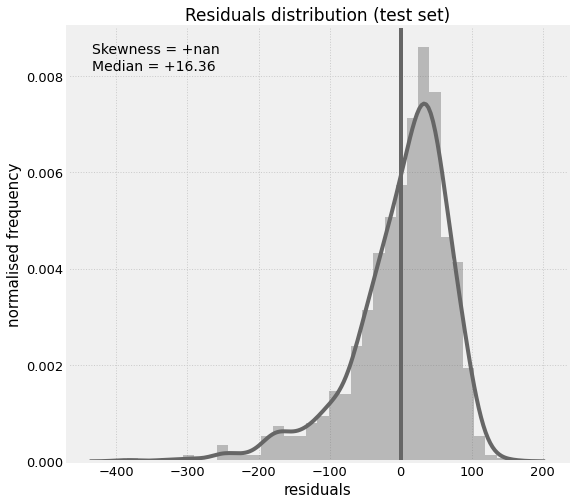

In [ ]:
from scipy.stats import skew

f, ax = plt.subplots(figsize=(8,8))
sns.distplot((total_df.loc['2019':,'yhat'] - total_df.loc['2019':,'y']), ax=ax, color='0.4')
ax.grid(ls=':')
ax.set_xlabel('residuals', fontsize=15)
ax.set_ylabel("normalised frequency", fontsize=15)
ax.grid(ls=':')

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

ax.text(0.05, 0.9, "Skewness = {:+4.2f}\nMedian = {:+4.2f}".\
        format(skew(total_df.loc['2019':,'yhat'] - total_df.loc['2019':,'y']), (total_df.loc['2019':,'yhat'] - total_df.loc['2019':,'y']).median()), \
        fontsize=14, transform=ax.transAxes)

ax.axvline(0, color='0.4')

ax.set_title('Residuals distribution (test set)', fontsize=17)

## Forecasting

In [ ]:
# two year forcast
future = prophet.make_future_dataframe(periods=365*3, freq='D')
future.tail(2)

,ds
2554,2020-02-27
2555,2020-02-28


In [ ]:
forecast = prophet.predict(future)

Text(17.475, 0.5, 'PM2.5 (ug/m3)')

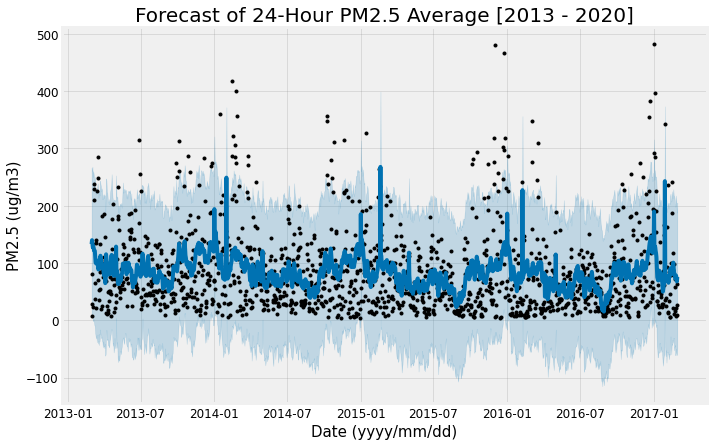

In [ ]:
#fig = prophet.plot(forecast, xlabel= 'Date (yyyy/mm/dd)', ylabel='PM2.5 (ug/m3)')
figsize=(20, 12)
fig = prophet.plot(forecast, xlabel='Date', ylabel='Value')
ax = fig.gca()
ax.set_title("Forecast of 24-Hour PM2.5 Average [2013 - 2020]", size=20)
ax.set_xlabel("Date (yyyy/mm/dd)", size=15)
ax.set_ylabel("PM2.5 (ug/m3)", size=15)

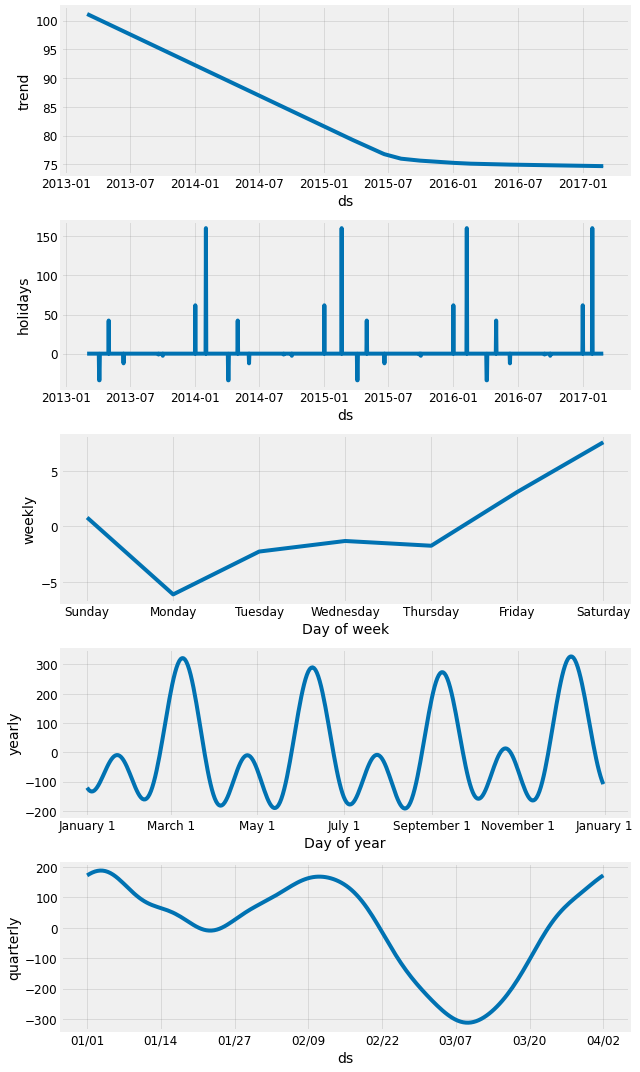

In [ ]:
fig1 = prophet.plot_components(forecast)

### Cross Validation

INFO:fbprophet:Making 3 forecasts with cutoffs between 2015-03-06 00:00:00 and 2016-02-29 00:00:00


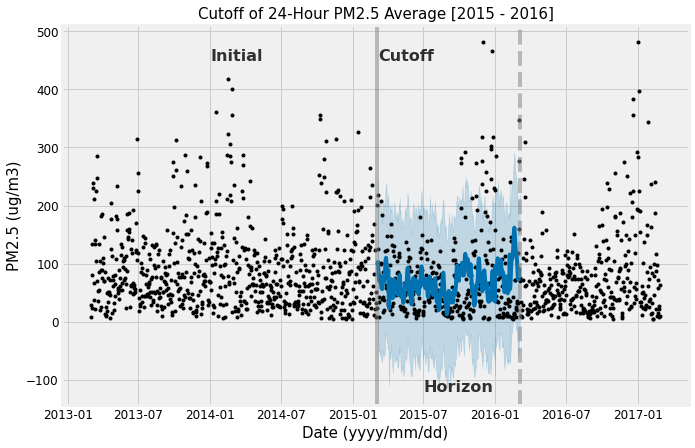

In [ ]:
from fbprophet.diagnostics import cross_validation
df_cv =  cross_validation(prophet, initial='730 days', period='180 days', horizon = '365 days')
cutoff = df_cv['cutoff'].unique()[0]
df_cv = df_cv[df_cv['cutoff'].values == cutoff]

fig = plt.figure(facecolor='w', figsize=(10, 7))
ax = fig.add_subplot(111)
ax.plot(prophet.history['ds'].values, prophet.history['y'], 'k.')
ax.plot(df_cv['ds'].values, df_cv['yhat'], ls='-', c='#0072B2')
ax.fill_between(df_cv['ds'].values, df_cv['yhat_lower'],
                df_cv['yhat_upper'], color='#0072B2',
                alpha=0.2)
ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
ax.set_title("Cutoff of 24-Hour PM2.5 Average [2015 - 2016]", size=15)
ax.set_xlabel("Date (yyyy/mm/dd)", size=15)
ax.set_ylabel("PM2.5 (ug/m3)", size=15)
ax.text(x=pd.to_datetime('2014-01-01'),y=450, s='Initial', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)
ax.text(x=pd.to_datetime('2015-03-07'),y=450, s='Cutoff', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)
ax.axvline(x=pd.to_datetime(cutoff) + pd.Timedelta('365 days'), c='gray', lw=4,
           alpha=0.5, ls='--')
ax.text(x=pd.to_datetime('2015-07-01'),y=-120, s='Horizon', color='black',
       fontsize=16, fontweight='bold', alpha=0.8);

In [ ]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
360,2016-03-01,72.565935,-58.402895,204.743014,118.333333,2015-03-06
361,2016-03-02,72.994239,-52.403296,203.276344,159.916667,2015-03-06
362,2016-03-03,84.944033,-36.324257,211.662408,277.000000,2015-03-06
363,2016-03-04,92.657251,-30.074812,213.832519,347.291667,2015-03-06
364,2016-03-05,93.549942,-27.257467,219.023584,69.958333,2015-03-06


In [ ]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days,3147.284360,56.100663,45.202852,0.963571,0.509243,0.944444
1,37 days,2847.263934,53.359760,43.251729,1.038226,0.528104,0.944444
2,38 days,2824.465716,53.145703,42.775477,1.046794,0.559423,0.944444
3,39 days,2692.507384,51.889376,41.288400,0.835621,0.528104,0.944444
4,40 days,2824.920879,53.149985,42.384138,0.820366,0.528104,0.944444


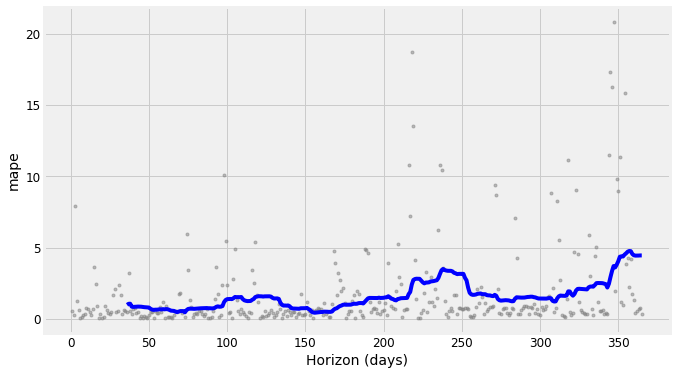

In [ ]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

## Air Quality Index (AQI)

In [ ]:
# Revised Breakpoints (µg/m3, 24-hour average)
def AQI_Breakpoints(i):
    if i >= 0.0 and i <= 12:
        return 'Good'
    if i >= 12.1 and i <= 35.4:
        return 'Moderate'
    if i >= 35.5 and i <= 55.4:
        return 'Unhealthy for Sensitive Groups'
    if i >= 55.5 and i <= 150.4:
        return 'Unhealthy'
    if i >= 150.5 and i <= 250.4:
        return 'Very Unhealthy'
    if i >= 250.5 and i <= 350.4:
        return 'Hazardous'
    if i >= 350.5 and i <= 500:
        return 'Very Hazardous'

In [ ]:
daily_avg_copy['AQI'] = daily_avg_copy['PM2.5'].apply(AQI_Breakpoints)

In [ ]:
daily_avg["AQI"].value_counts()

Unhealthy                         627
Moderate                          323
Unhealthy for Sensitive Groups    234
Very Unhealthy                    138
Good                               80
Hazardous                          44
Very Hazardous                     11
Name: AQI, dtype: int64

In [ ]:
forecast_df = forecast[['ds', 'yhat']]

forecast_df['AQI'] = forecast_df['yhat'].apply(AQI_Breakpoints)

In [ ]:
aqi_forecast = forecast_df[0:1461].dropna()
aqi_future = forecast_df[1461:2555].dropna()

In [ ]:
aqi_forecast["AQI"].value_counts()

Unhealthy                         1280
Unhealthy for Sensitive Groups     144
Moderate                            26
Very Unhealthy                       8
Hazardous                            1
Name: AQI, dtype: int64

In [ ]:
aqi_future["AQI"].value_counts()

Unhealthy                         810
Unhealthy for Sensitive Groups    183
Moderate                           67
Very Unhealthy                     14
Good                               10
Hazardous                           1
Name: AQI, dtype: int64